#  Hierarchical modeling applied to a meta-analysis

In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

from scipy.stats import norm

import matplotlib.pyplot as plt

In [2]:
ALPHA = 0.05

In [3]:
Dat = pd.read_csv("../Data/MetanalysisCombiningStudies.csv", sep=";")

In [4]:
Dat.head()

,Study,ControlDeaths,ControlTotal,TreatedDeaths,TreatedTotal
0,1,3,39,3,38
1,2,14,116,7,114
2,3,11,93,5,69
3,4,127,1520,102,1533
4,5,27,365,28,355


Meta-analysis is a process of summarizing and integrating the findings of research studies in a particular area.

The data in the example summarize mortality after myocardial infarction in 22 clinical trials, each consisting of
two groups of heart attack patients randomly allocated to receive or not receive beta-blockers (a family of drugs that affect the central nervous system and can relax the heart muscles). The aim of a meta-analysis is to provide a combined analysis of the studies that indicates the overall strength of the evidence for a beneficial effect of the treatment under study.

If clinical trial $j$ involves the use of $n_{0j}$ subjects in the control group and $n_{1j}$ in the treatment group, giving rise to $y_{0j}$ and $y_{1j}$ deaths in control and treatment groups, respectively, then the usual sampling model involves two independent binomial distributions with probabilities $p_{0j}$ and $p_{1j}$, respectively. Estimands of interest include the odds ratio $$\rho_j=\frac{\frac{p_{1j}}{1-p_{1j}}}{\frac{p_{0j}}{1-p_{0j}}}.$$ However, for a number of reasons, including interpretability and the fact that its posterior distribution is close to normality, we concentrate on inference for the logarithm of the odds ratio, which we label $\theta_j=\log\rho_j$.

We calculate the logarithms of the odds: $$y_j=\log\left(\frac{y_{1j}}{n_{1j}-y_{1j}}\right)-\log\left(\frac{y_{0j}}{n_{0j}-y_{0j}}\right),$$ with approximate variance $$\sigma_j^2=\frac{1}{y_{1j}}+\frac{1}{n_{1j}-y_{1j}}+\frac{1}{y_{0j}}+\frac{1}{n_{0j}-y_{0j}}$$

In [5]:
LogOdds = np.log(Dat["TreatedDeaths"]/(Dat["TreatedTotal"] - Dat["TreatedDeaths"])) - np.log(Dat["ControlDeaths"]/(Dat["ControlTotal"] - Dat["ControlDeaths"]))

Sigma2 = 1/Dat["TreatedDeaths"] + 1/(Dat["TreatedTotal"]-Dat["TreatedDeaths"]) + 1/Dat["ControlDeaths"] + 1/(Dat["ControlTotal"]-Dat["ControlDeaths"])
Sigma = np.sqrt(Sigma2)

We model $$y_j|\theta_j,\sigma_j\sim\textsf{Normal}(\theta_j,\sigma_j^2),$$ $$\theta_j\sim\textsf{Normal}(\mu,\tau^2),$$ $$p(\mu)\propto 1,$$ $$p(\tau)\propto 1.$$

In [6]:
with pm.Model() as ModelMetaAnalysis:
    Mu = pm.Flat("Mu")
    Tau = pm.HalfFlat("Tau")

    Theta = pm.Normal("Theta", mu=Mu, sigma=Tau, shape=len(LogOdds))

    Y = pm.Normal("LogOdds", mu=Theta, sigma=Sigma, observed=LogOdds)

    TraceMetaAnalysis = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mu, Tau, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 724 divergences after tuning. Increase `target_accept` or re

We obtain the median, and ETI interval for $\theta_j$.

In [7]:
ThetaSummary = az.summary(TraceMetaAnalysis, stat_focus='median', hdi_prob=1-ALPHA, var_names="Theta", kind='stats')

In [8]:
Dat["log_odds"] = LogOdds.round(3)
Dat["sigma"] = Sigma.round(3)
Dat['eti_' + str(ALPHA/2*100)+'%'] =  ThetaSummary['eti_' + str(ALPHA/2*100)+'%'].reset_index(drop=True)
Dat["median"] = ThetaSummary['median'].reset_index(drop=True)
Dat['eti_' + str((1-ALPHA/2)*100)+'%'] =  ThetaSummary['eti_' + str((1-ALPHA/2)*100)+'%'].reset_index(drop=True)

In [9]:
Dat.head()

,Study,ControlDeaths,ControlTotal,TreatedDeaths,TreatedTotal,log_odds,sigma,eti_2.5%,median,eti_97.5%
0,1,3,39,3,38,0.028,0.850,-0.554,-0.251,0.130
1,2,14,116,7,114,-0.741,0.483,-0.633,-0.282,-0.003
2,3,11,93,5,69,-0.541,0.565,-0.590,-0.277,0.021
3,4,127,1520,102,1533,-0.246,0.138,-0.422,-0.279,-0.052
4,5,27,365,28,355,0.069,0.281,-0.410,-0.234,0.138


We obtain the median, and interval predictions for $\mu$, $\tau$.

In [10]:
az.summary(TraceMetaAnalysis, stat_focus='median', hdi_prob=1-ALPHA, var_names=["Mu", "Tau"], kind='stats')

,median,mad,eti_2.5%,eti_97.5%
Mu,-0.268,0.026,-0.364,-0.108
Tau,0.106,0.072,0.015,0.308


In [11]:
PosteriorMu = TraceMetaAnalysis.posterior.Mu.values.ravel()
PosteriorTau = TraceMetaAnalysis.posterior.Tau.values.ravel()

In [12]:
NewTheta = norm.rvs(size=len(PosteriorMu), loc=PosteriorMu, scale=PosteriorTau)
np.quantile(NewTheta, [0.025,0.5,0.975]).round(3)

array([-0.571, -0.265,  0.091])

Histogram of $\tilde\theta$

Text(0, 0.5, '$p(\\theta|\\vec{Y})$')

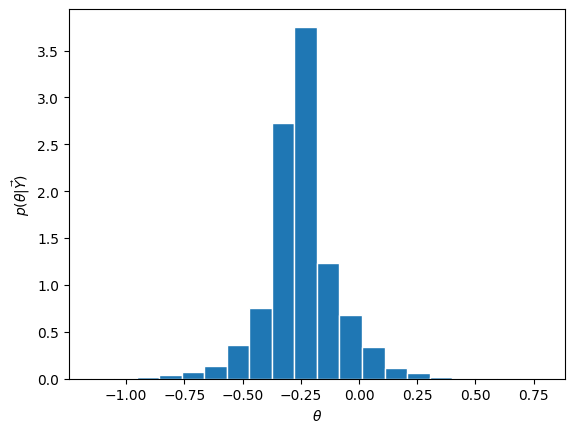

In [13]:
_, _, _ = plt.hist(NewTheta, bins=20, edgecolor='w', density=True)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|\vec{Y})$')

In [14]:
def V_mu(tau):
    return 1 / (1/(Sigma2+tau)).sum()

V_mu_vect = np.vectorize(V_mu)

def mu_hat(tau):
    return (LogOdds/(Sigma2+tau)).sum() * V_mu(tau)

mu_hat_vect = np.vectorize(mu_hat)

def V_j(j, tau):
    return 1 / (1/Sigma[j]**2+1/tau**2)

V_j = np.vectorize(V_j)

def expected_theta(j, tau):
    return (LogOdds[j]/Sigma[j]**2 + mu_hat(tau)/tau**2) * V_j(j, tau)

expected_theta = np.vectorize(expected_theta)

def std_theta(j, tau):
    return np.sqrt(V_j(j, tau) + 1/tau**4 * V_mu(tau) * V_j(j, tau)**2)

std_theta = np.vectorize(std_theta)

The posterior interval for $\mu$, exponentiated.

In [15]:
np.exp(np.quantile(PosteriorMu, [ALPHA/2, 0.5, 1-ALPHA/2])).round(3)

array([0.695, 0.765, 0.898])

The posterior interval of $\mu$ from complete pooling, that is $\tau=0$.

In [16]:
norm.ppf([ALPHA/2, 0.5, 1-ALPHA/2], loc=mu_hat(0), scale=np.sqrt(V_mu(0))).round(3)

array([-0.359, -0.26 , -0.161])

The posterior interval of $\mu$ (exponentiated) from complete pooling, that is $\tau=0$.

In [17]:
np.exp(norm.ppf([ALPHA/2, 0.5, 1-ALPHA/2], loc=mu_hat(0), scale=np.sqrt(V_mu(0)))).round(3)

array([0.699, 0.771, 0.851])

In the original published discussion of these data, it was remarked that it seems and 'unusually narrow range of uncertainty'. The Bayesian analysis suggests that this was due to the use of an inappropriate model that had the effect of claiming all the studies were identical. In mathematical terms, complete pooling makes the assumption that the parameter $\tau$ is exactly zero, whereas the data supply evidence that $\tau$ might be close to zero, but might also plausibly be as high as 0.3.

We make a scatterplot of the crude effect estimates vs. the posterior median effect estimates for the 22 studies. We observe that the studies with the smallest sample sizes are partially pooled the most toward the mean $\mu$ (in this case estimated by its posterior median).

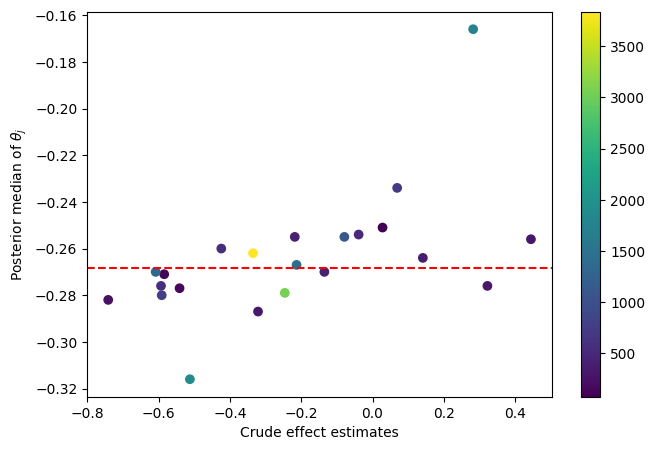

In [18]:
plt.figure(figsize=(7.5,5))
plt.scatter(Dat["log_odds"], Dat["median"], c=Dat["ControlTotal"]+Dat["TreatedTotal"])
plt.axhline(np.median(TraceMetaAnalysis.posterior.Mu.values), color='r', linestyle='--')
plt.xlabel(r"Crude effect estimates")
plt.ylabel(r"Posterior median of $\theta_j$")
plt.colorbar()